# Config

Load Libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

import tensorflow as tf

from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

import visualkeras

from datetime import datetime

import time
from sklearn.metrics import multilabel_confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay as cmd

import scikitplot as skplt

import shap

import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

import warnings
warnings.filterwarnings('ignore')

Configuration of important paths.

In [2]:
raw_path = 'data/raw'
split_path = 'data/split'

# Load model and create Test Data

Load the final model.

In [2]:
model = tf.keras.models.load_model('models/model_final.h5')

Apply normalization and rescaling to the test-dataset with Keras' ImageDataGenerator.

In [4]:
classes = os.listdir(split_path + '/test')
if '.DS_Store' in classes:
        classes.remove('.DS_Store')

test_size = 0

for c in classes:
    test_size += len(os.listdir(split_path + '/test/' + c)) - 1

In [5]:
test_gen = ImageDataGenerator(rescale=1./255 )

test_data = test_gen.flow_from_directory(
    directory = split_path + '/test', 
    target_size=(224, 224), 
    color_mode='rgb', 
    class_mode='sparse', 
    batch_size=test_size, 
    shuffle=True, 
    seed=1,
    interpolation='nearest'
)

X_test,y_true = test_data.next()
y_true = y_true.astype(int)
y_labels = list(test_data.class_indices.keys())

Found 361 images belonging to 3 classes.


# Evaluate model's performance

The aim of this evaluation is to inspect how well the model performs on fresh data it has never seen before.

## Create predictions

In [6]:
pred_proba = model.predict(X_test)
pred_binary = np.argmax(pred_proba, axis=1)

## Accuracy, Confusion Matrix, Classification Report

In [10]:
cm = multilabel_confusion_matrix(y_true, pred_binary)

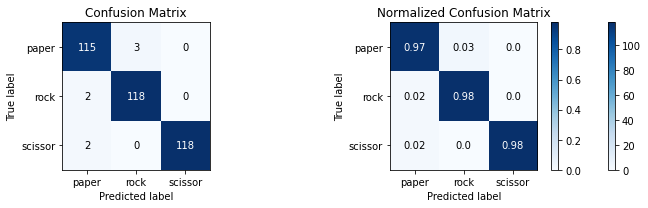

In [11]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

skplt.metrics.plot_confusion_matrix(y_true, pred_binary, normalize=False, ax = ax1)
skplt.metrics.plot_confusion_matrix(y_true, pred_binary, normalize='pred', ax = ax2)

plt.setp((ax1, ax2), 
         xticks=list(range(0, len(y_labels))), xticklabels=y_labels, 
         yticks=list(range(0, len(y_labels))), yticklabels=y_labels )

fig.tight_layout()

plt.show()

**Result:** Very little predictions are false. Scissors is the most reliable prediction. Paper gets mistaken as a rock for three times. The most uncertain prediction is paper, while the probability for true predictions are still very high.

In [15]:
print(classification_report(y_true = y_true, 
                            y_pred = pred_binary, 
                            labels = list(range(0, len(y_labels))),
                            target_names = y_labels))

              precision    recall  f1-score   support

       paper       0.97      0.97      0.97       118
        rock       0.98      0.98      0.98       120
     scissor       1.00      0.98      0.99       120

    accuracy                           0.98       358
   macro avg       0.98      0.98      0.98       358
weighted avg       0.98      0.98      0.98       358



**Result:** The overall accuracy reaches 98%, which is even higher than the validation-accurarcy. <br>
Recall, Precision and F1-Score are very high aswell.

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

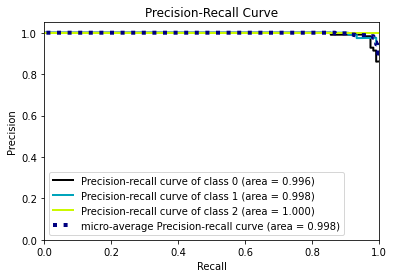

In [16]:
skplt.metrics.plot_precision_recall_curve(y_true, pred_proba)

**Result:** The illustration confirms previous results, that recall and precision is very high for each class.

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

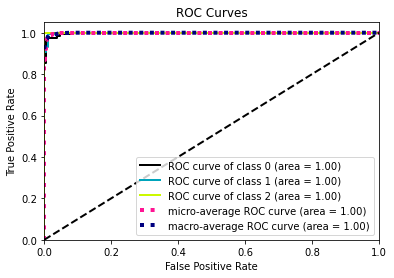

In [17]:
skplt.metrics.plot_roc_curve(y_true, pred_proba)

**Result:** The illustration confirms previous results, that the true positive is very high for each class while the false positive rate is very low.

## Inspect individual predictions

Inspecting individual predictions can help to understand the models behaviour. Particular interesint are images that have been classified false. 

In [18]:
def plot_prediction_proba(i, predictions, true_label, model_input, class_names):
    true_label, img, pred = true_label[i], model_input[i], predictions[i]

    plt.imshow(img)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    cell_text = []

    for r in range(len(predictions[i])):
        cell_text.append([class_names[r],'{:2.2f}%'.format(round(predictions[i][r]*100,2))])
        cell_text = sorted(cell_text,key=lambda l:l[1], reverse = True)

    cell_text.append(['True class', class_names[true_label]])
    
    plt.table(cellText = cell_text, loc = 'bottom')
    
    if np.argmax(pred) == true_label:
        label_color = 'green'
        title = 'True'
    else:
        label_color = 'red'
        title = 'False'
    plt.title(title, color = label_color)



Plot random images with their predicted probabilities for each class.

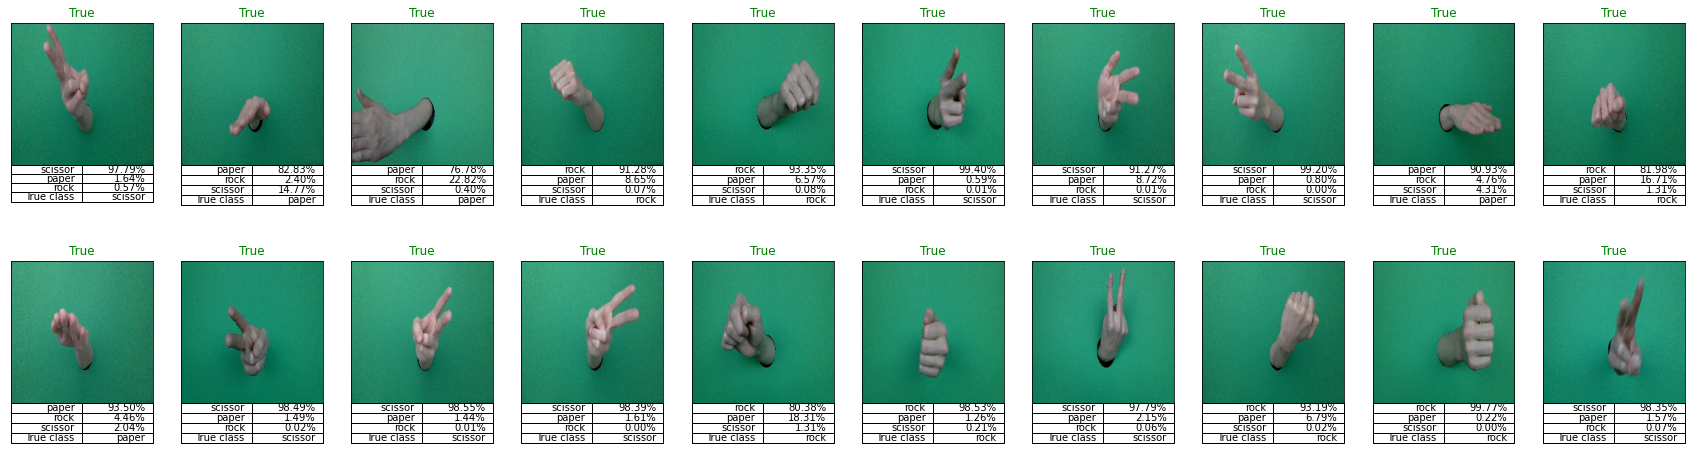

In [19]:
plt.figure(figsize=(30,7.5))

rnd_imgs = np.random.randint(0, len(pred_proba)-1, 20)
sp = 1

for i in rnd_imgs:
    plt.subplot(2,10,sp)
    sp += 1
    plot_prediction_proba(i ,pred_proba, y_true, X_test, y_labels)
    plt.subplots_adjust(hspace = .4)

plt.show()

**Result:** The model does well on all classes, independend whether the hand gesture is made straight into the camera or to the left/right/bottom/up. For most of the images, it is very confident in its prediction (winning probabilities are mostly over 90%).

Plot images classified false to analyse, if there are pattern in these errors.

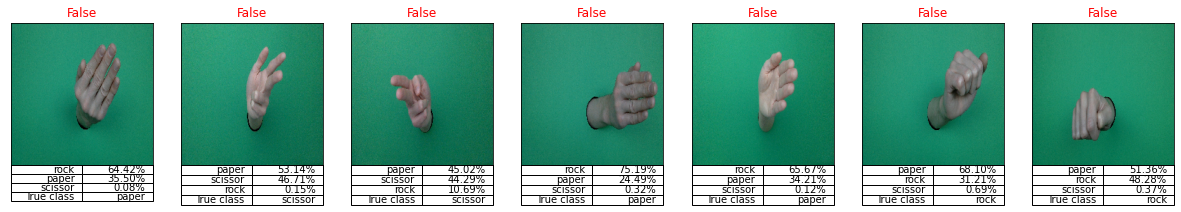

In [20]:
states = y_true!=pred_binary
pred_false = np.where(states)[0]

plt.figure(figsize=(30,7.5))

i = 1
for p in pred_false:
    plt.subplot(2,10,i)
    i += 1
    plot_prediction_proba(p ,pred_proba, y_true, X_test, y_labels)
    plt.subplots_adjust(hspace = .4)

plt.show()


**Result:** Overall, it is noticeable that the false predictions have very mixed probabilities, with many of them almost 50% / 50%. <br>
From the very little false predictions, no error-pattern can be derived.

## Inspect individual predictions based on images done with webcam

Initial guesses can be further analyzed with this feature by quickly creating images and classifying them immediately.

In [21]:
def test_webcam_img (true_label):
    
    cam = cv2.VideoCapture(0)
    time.sleep(0.1)
    ret, frame = cam.read()

    if not ret:
        print('failed to grab frame')
        return

    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    cam.release()
    
    test_img = cv2.resize(frame, (224, 224)) 

    test_img = test_img.reshape([1,224,224,3])
    pred = model.predict(test_img)
    plot_prediction_proba(0 ,pred, [y_labels.index(true_label)], test_img, y_labels)

In [28]:
#test_webcam_img('paper')

In [29]:
#test_webcam_img('rock')

In [30]:
#test_webcam_img('scissor')

**Result:** Testing in "production"-scenario showed...

* overall, most of the predictions were true
* predictions get worse on poorly lid images
* predictions get worse with increasing distractions, e.g. faces / objects in the background

# Understand the model (IML Methods)

## Plot model structure

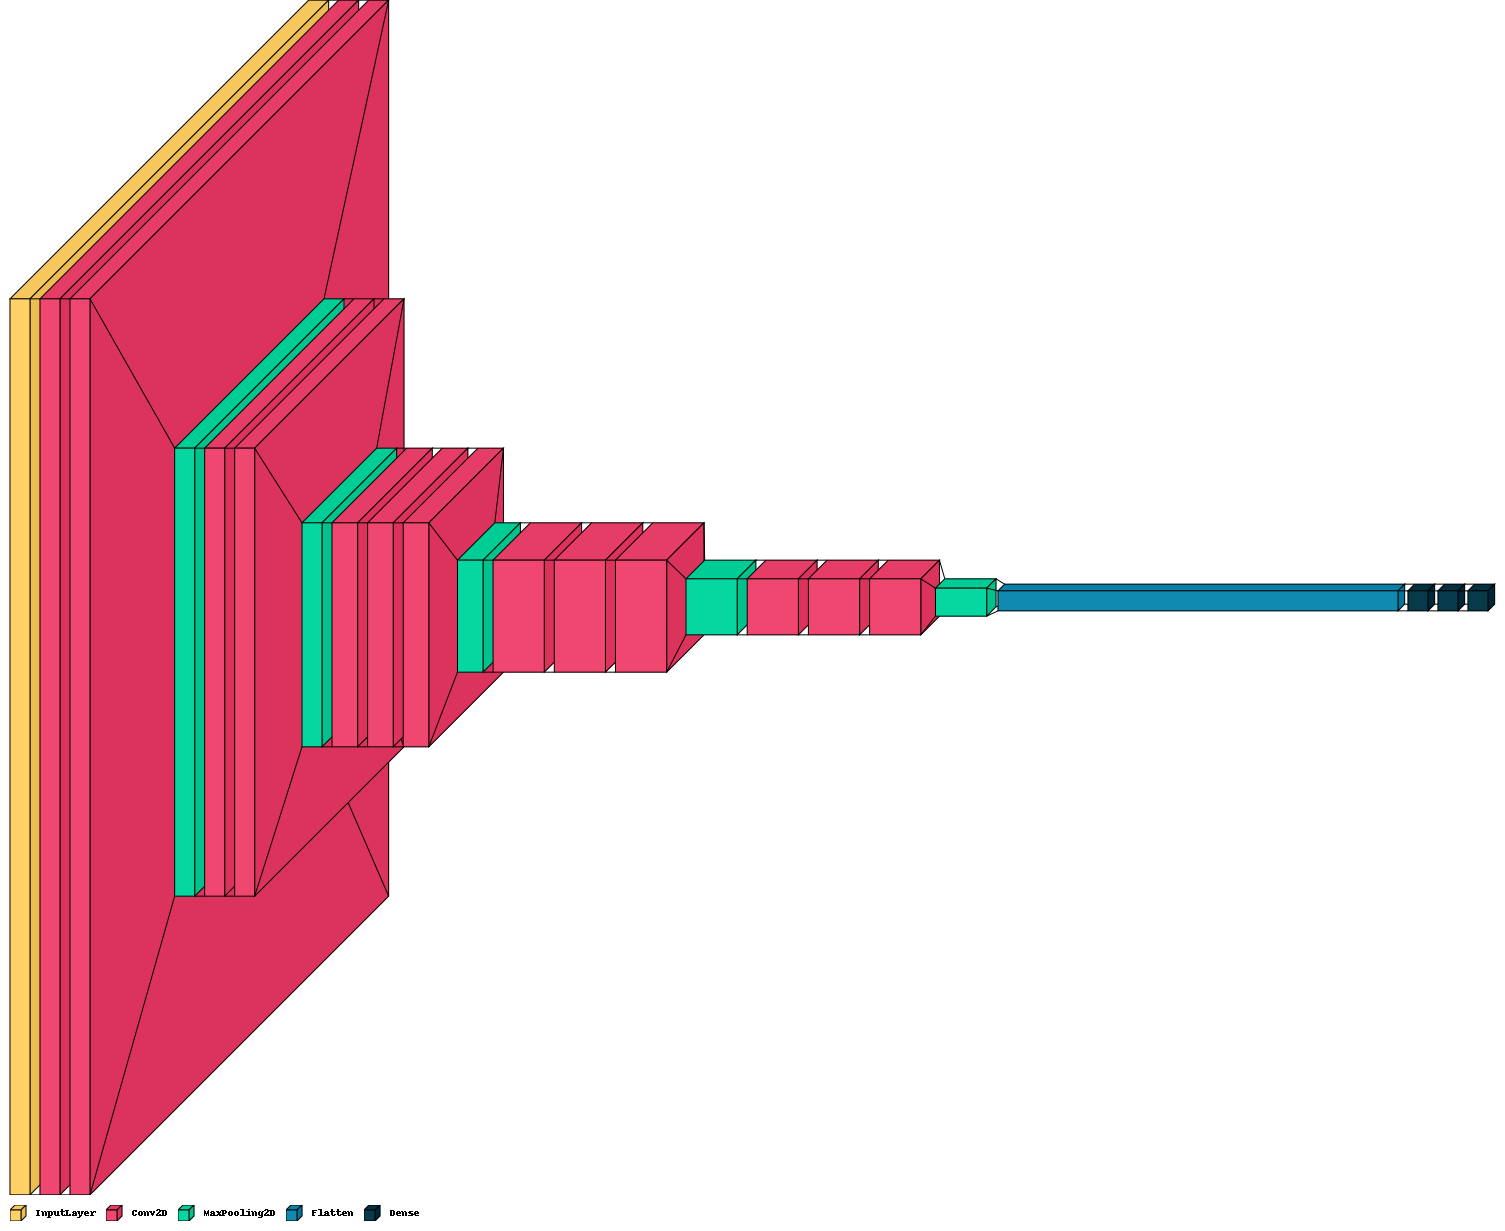

In [46]:
visualkeras.layered_view(model, legend=True, spacing=10) 

**Result:** The model consists of 5 convoluation-blocks with 2 to 3 convolution layers and a maxpooling layer at each blocks' end. After that, a flatten-layer flattens the multidimensional arrays to a 1D-matrix, which gets passed through three dense layers to come out with a prediction.

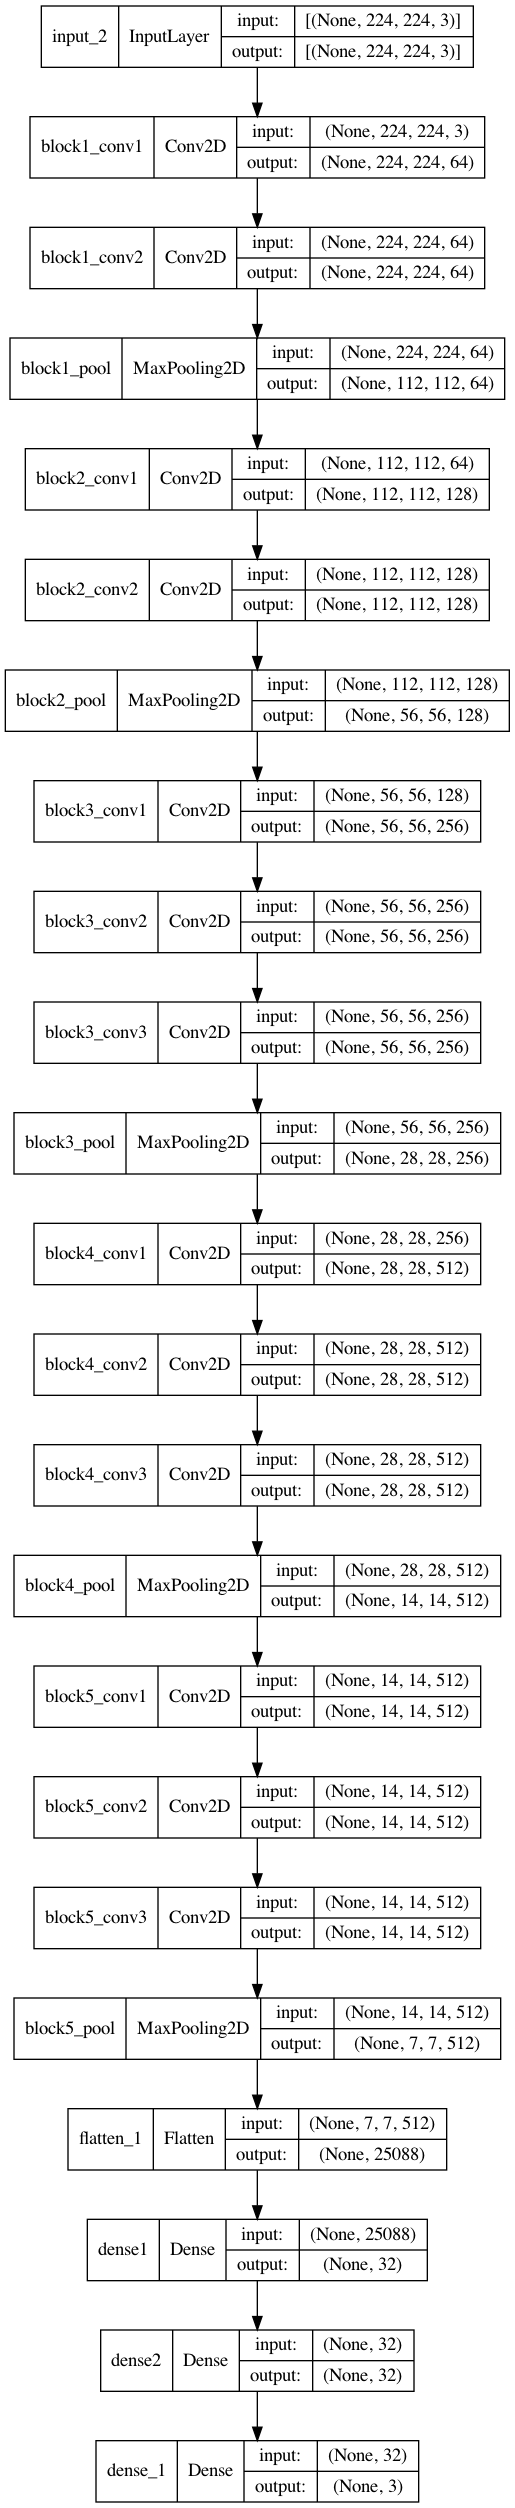

In [35]:
tf.keras.utils.plot_model(model, to_file='doc_imgs/model_structure.png', show_shapes=True)

**Result:** The VGG16 model increases in filters, starting from 64 up to 512, which results in 25088 inputs for the first dense layer. The final dense layers (each 32 nodes) shrink this down to a prediction in three classes.

## Explaining features learned by printing weights of model layers

Each Convolution-layer applies multiple filters on the image to generate feature maps. The filters can be plotted to understand what they are looking for.

In [11]:
def display_filters(max_num_of_layers):
    layer_count = 1
    for layer in model.layers:
        if layer_count > max_num_of_layers:
            return
        if 'conv' in layer.name:
            layer_count += 1
            weights, bias= layer.get_weights()
            print('Layer: ' + str(layer.name))
            
            #normalize filter values between  0 and 1 for visualization
            f_min, f_max = weights.min(), weights.max()
            filters = (weights - f_min) / (f_max - f_min)  
            print('Filter size: ' + str(filters.shape[3]))
            filter_cnt=1
            
            plt.figure(figsize=(40,round(number = filters.shape[0]*2)))
            #plotting all the filters
            for i in range(filters.shape[3]):
                #get the filters
                filt=filters[:,:,:, i]
                #plotting each of the channel, color image RGB channels
                for j in range(round(filters.shape[0])):
                    ax= plt.subplot(filters.shape[0], filters.shape[3], filter_cnt)
                    ax.set_xticks([])
                    ax.set_yticks([])
                    plt.imshow(filt[:,:, j])
                    filter_cnt+=1
            plt.show()

Layer: block1_conv1
Filter size: 64


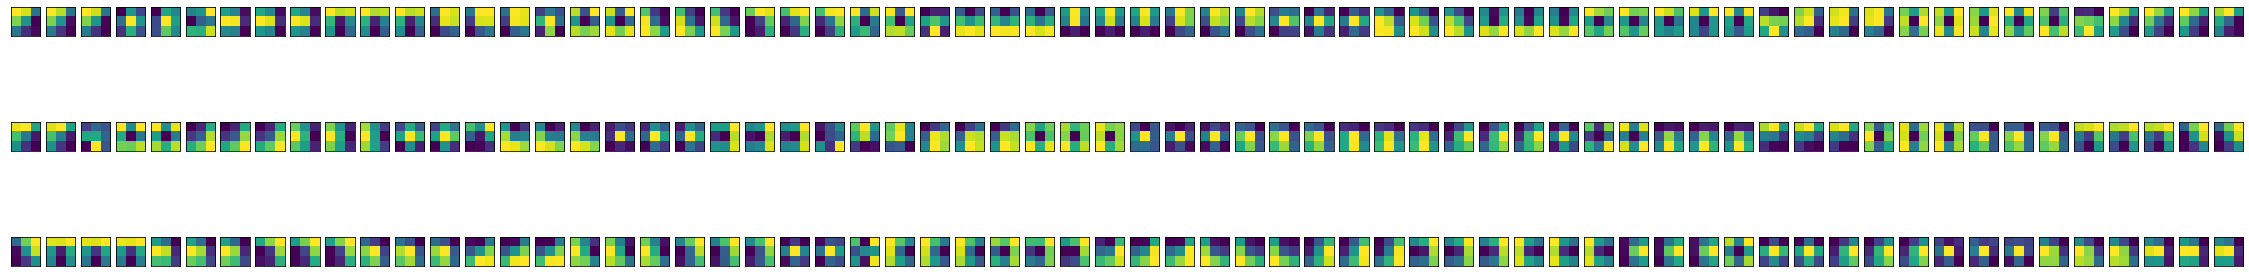

In [12]:
display_filters(1)

Limited output to only one layer in order to keep it simple.

**Result:** There is a huge variety in the filters-structure. Each filter has a kernel-size of 3x3. Each row represents one color-channel.<br>
However, interpretation based on filters alone is very limited, especially since it is impossible to print **and** understand every filter of each layer.

## Explaining features learned by printing feature maps for individual images

Applying the filters on an image creates a feature map, which can be plotted aswell.

In [13]:
def display_feature_maps(img, max_num_layers):

  successive_outputs = [layer.output for layer in model.layers[1:]]

  visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

  x = img.reshape((1,224,224,3))

  successive_feature_maps = visualization_model.predict(x)
  # Retrieve are the names of the layers, so can have them as part of our plot
  layer_names = [layer.name for layer in model.layers]

  num_layers = 1
  for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if max_num_layers != 'all':
      if num_layers > max_num_layers:
        return
    if len(feature_map.shape) == 4 and 'conv' in layer_name: # make shure to only analyse not fully-connected layers
      num_layers += 1
      n_features = feature_map.shape[-1]  # number of features in the feature map
      size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
      
      display_grid = np.zeros((size, size * n_features))
      
      # Postprocess the feature to be visually palatable
      for i in range(n_features):
        x  = feature_map[0, :, :, i]
        x -= x.mean()
        x /= x.std ()
        x *=  64
        x += 128
        x  = np.clip(x, 0, 255).astype('uint8')
        # Tile each feature map into a horizontal grid
        display_grid[:, i * size : (i + 1) * size] = x
  # Display the feature maps per layer
      scale = 40. / n_features
      plt.figure( figsize=(scale * n_features, scale) )
      plt.title ( layer_name + ' - no of filters: ' + str(n_features))
      plt.grid  ( False )
      plt.xticks([])
      plt.yticks([])
      plt.imshow( display_grid, aspect='auto', cmap='viridis' )

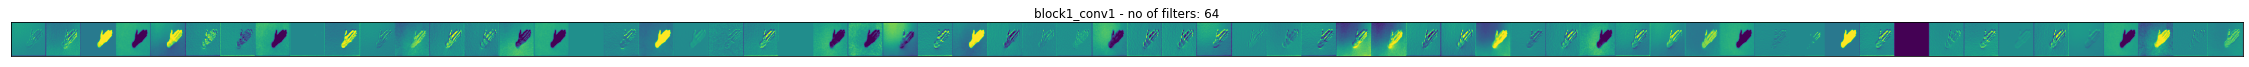

In [15]:
display_feature_maps(X_test[100], 1)

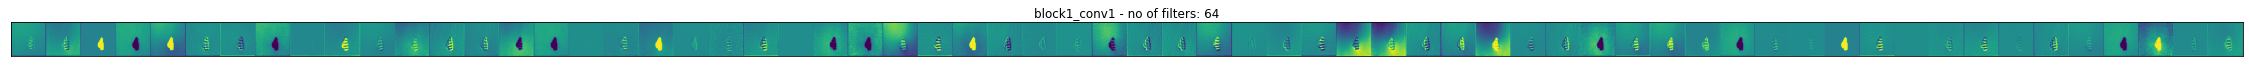

In [21]:
display_feature_maps(X_test[5], 1)

**Result:** The feature maps illustrate, how different parts of the images, like edges, curves, areas get highighted. <br>
Yet, interpretation is still limited, because the complexity from 64, 128, to 256 to 512 feature maps for a single image is too high to have a chance of understanding what the model is looking for.

## Explaining individual predictions with SHAP

SHAP helps to explain individual predictions by highlighting pixels of the images indicating whether these pixels increased or decreased the probability for a certain prediction.



Define explainer.

In [7]:
background = X_test[np.random.choice(X_test.shape[0], 100, replace=False)]
e = shap.DeepExplainer(model, background)

Create temporary datasets with one image for each class with prediction = 'true' and prediction = 'false'.

In [8]:
state_false = y_true!=pred_binary
pred_false = np.where(state_false)[0]

state_true = y_true==pred_binary
pred_true = np.where(state_true)[0]

x_Test_one_true_per_class = []
x_Test_one_false_per_class = []

for i in range(len(y_labels)):
    x_Test_one_true_per_class.append(np.zeros([224,224,3]))
    x_Test_one_false_per_class.append(np.zeros([224,224,3]))

    for c in pred_true:
        if y_true[c] == i:
            x_Test_one_true_per_class[i] = X_test[c]
    for c in pred_false:
        if y_true[c] == i:
            x_Test_one_false_per_class[i] = X_test[c] 
            
x_Test_one_true_per_class = np.array(x_Test_one_true_per_class)
x_Test_one_false_per_class = np.array(x_Test_one_false_per_class)

SHAP Values for true classfified images.

In [3]:
shap_values_trues = e.shap_values(x_Test_one_true_per_class, check_additivity=False)

                              paper                 rock                 scissors


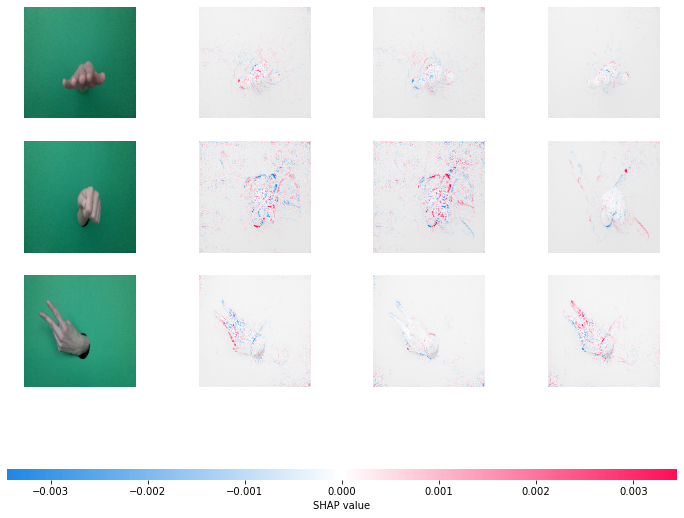

In [11]:
print('                              paper                 rock                 scissors')
shap.image_plot(shap_values_trues, x_Test_one_true_per_class)

SHAP Values for false classified images.

In [12]:
shap_values_falses = e.shap_values(x_Test_one_false_per_class, check_additivity=False)

                              paper                 rock                 scissors


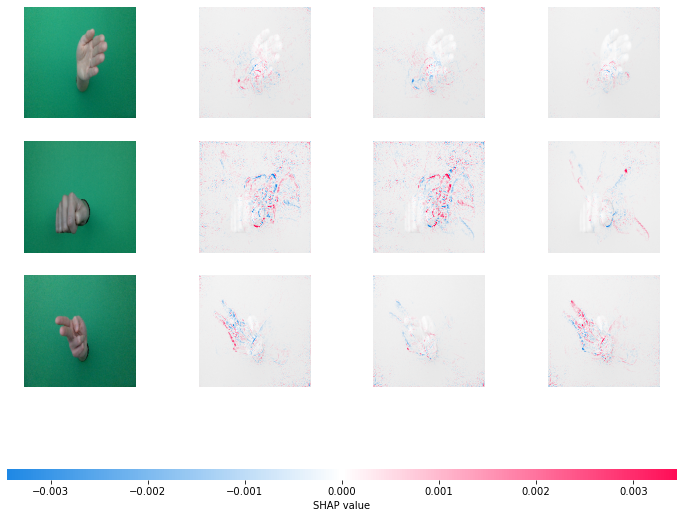

In [14]:
print('                              paper                 rock                 scissors')
shap.image_plot(shap_values_trues, x_Test_one_false_per_class)

**Result:** Red pixels increase the model's output while blue pixels decrease the output. <br>
With the exception of the scissors-image, the results are hard to interpret. Overall, it is a good sign that the highlighted pixels are centred around the hand. This means, that the model is not affected by noise to a high degree. <br>

## Explaining individual predictions with LIME

LIME offers a similar interpretation method by highlighting bigger parts of the images (superpixels) and tag them whether they had a positiv or negativ impact on the prediction.

In [22]:
explainer = lime_image.LimeImageExplainer(random_state=1)

In [23]:
def lime_explain(index, X_array, y_array):
     i = index

     explanation = explainer.explain_instance(
          X_array[i].astype('double'), 
          model.predict
     )

     pred = model.predict(X_array[i].reshape((1,224,224,3)))

     plt.imshow(X_array[i])
     image, mask = explanation.get_image_and_mask(
          pred.argmax(axis=1)[0],
          positive_only=False, 
          hide_rest=False)
     plt.imshow(mark_boundaries(image, mask, color=(0.2, 0.2, 0)))
     
     plt.grid(False)
     plt.xticks([])
     plt.yticks([])

     cell_text = []

     for r in range(len(pred[0])):
          cell_text.append([y_labels[r],'{:2.2f}%'.format(round(pred[0][r]*100,2))])
          cell_text = sorted(cell_text,key=lambda l:l[1], reverse = True)

     cell_text.append(['True class', y_labels[y_array[i]]])
     
     plt.table(cellText = cell_text, loc = 'bottom')
     
     if np.argmax(pred) == y_array[i]:
          label_color = 'green'
          title = 'True'
     else:
          label_color = 'red'
          title = 'False'
     plt.title(title, color = label_color)

### Examine one example per class, where the model is confident in its prediction.

100%|██████████| 1000/1000 [06:15<00:00,  2.67it/s]


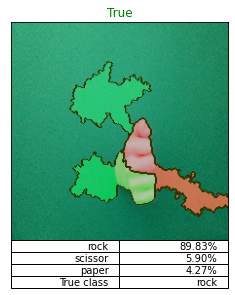

In [79]:
lime_explain(5, X_test, y_true)

100%|██████████| 1000/1000 [06:06<00:00,  2.73it/s]


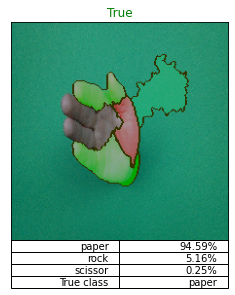

In [80]:
lime_explain(6, X_test, y_true)

100%|██████████| 1000/1000 [05:00<00:00,  3.33it/s]


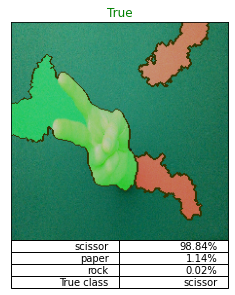

In [81]:
lime_explain(7, X_test, y_true)

**Result:** The examples show, that the model does oeverall well on catching the hand and making decisions based on the hand. <br>
However, there are also areas highlighted next to the hand. This could either be random noise trained by overfitting or signs, that the model would expect something different in this area for another prediction, e.g. a thumb held up. <br>

In the end, these assumptions can't be validated because firstly only a couple of images are examinated and because LIME does not explain its reasons why it is highlighting certain areas.

### Examine one example per class, where the model is not confident in its prediction or predicts false.

100%|██████████| 1000/1000 [05:26<00:00,  3.06it/s]


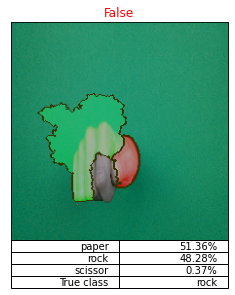

In [60]:
lime_explain(284, X_test, y_true)

100%|██████████| 1000/1000 [04:56<00:00,  3.37it/s]


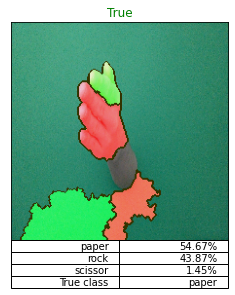

In [56]:
lime_explain(10, X_test, y_true)

100%|██████████| 1000/1000 [05:56<00:00,  2.80it/s]


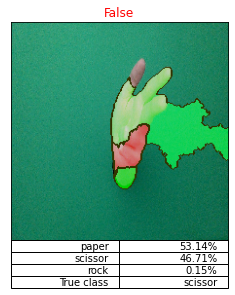

In [61]:
lime_explain(99, X_test, y_true)

**Result:** Analyzing images where the model is uncertain can reveal weaknesses of the model. <br>
For example, in two of the three images, a streched index finger made the model think it sees 'paper', while the rest the hand made the model tend towards scissors or rock, because the fingers bent are part of these gestures. <br>

Again, the limitations of these interpretations have to been taken into account and therefore, this interpretation should be taken with caution.